<a href="https://colab.research.google.com/github/GarlandZhang/pg-toons/blob/master/cartoongan_impl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -r keras-contrib/ 
# !pip uninstall -y tensorflow-gpu==2.0.0-alpha0
# !pip uninstall -y tensorflow
# !pip install tensorflow-gpu==2.0.0-alpha0
!git clone https://www.github.com/keras-team/keras-contrib.git \
    && cd keras-contrib \
    && pip install git+https://www.github.com/keras-team/keras-contrib.git \
    && python convert_to_tf_keras.py \
    && USE_TF_KERAS=1 python setup.py install
# clear_output()
!pip install -q  --no-deps tensorflow-addons~=0.7

Cloning into 'keras-contrib'...
remote: Enumerating objects: 3634, done.
remote: Total 3634 (delta 0), reused 0 (delta 0), pack-reused 3634
Receiving objects: 100% (3634/3634), 861.24 KiB | 14.60 MiB/s, done.
Resolving deltas: 100% (2330/2330), done.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-smo4v0kw
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-smo4v0kw
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=15dde4668bbd85fa7bcc5afe99ec3275914f872aea5fd5f91d129d401f40f160
  Stored in directory: /tmp/pip-ephem-wheel-cache-7chpulhf/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
Changed imports in 73 files.
Those files were found in the directory /content/keras-contrib
running install
running bdist_egg
running egg_info
creating tf_keras_contrib.egg-info
writing tf_keras_contrib.egg-info/PKG-INFO

In [96]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer, InputSpec, DepthwiseConv2D, Conv2D, BatchNormalization, Add, ReLU, LeakyReLU, ZeroPadding2D, Activation, LeakyReLU
import tensorflow_addons as tfa

import os
import gc
from glob import glob
from itertools import product
from random import choice

from imageio import imwrite
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras.applications import VGG19

import gc

import matplotlib.pyplot as plt
import math
import pickle

In [3]:
"""
Not sure what this does
"""

class ReflectionPadding2D(Layer):
  def __init__(self, padding=(1, 1), **kwargs):
    super(ReflectionPadding2D, self).__init__(**kwargs)
    padding = tuple(padding)
    self.padding = ((0, 0), padding, padding, (0, 0))
    self.input_spec = [InputSpec(ndim=4)]

  def compute_output_shape(self, s):
    return s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3]

  def call(self, x):
    return tf.pad(x, self.padding, "REFLECT")

In [4]:
def get_padding(pad_type, padding):
  if pad_type == 'reflect':
    return ReflectionPadding2D(padding)
  elif pad_type == 'constant':
    return ZeroPadding2D(padding)
  else:
    raise ValueError(f'Invalid padding type: {pad_type}')

In [5]:
def get_norm(norm_type):
  if norm_type == 'instance':
    return tfa.layers.InstanceNormalization()
  elif norm_type == 'batch':
    return BatchNormalization()
  else:
    raise ValueError(f'Invalid norm type: {norm_type}')

In [6]:
class FlatConv(Model):
  def __init__(self,
               filters,
               kernel_size,
               norm_type='instance',
               pad_type='constant',
               **kwargs):
    super(FlatConv, self).__init__(name='FlatConv')
    """
    # assuming stride=1, remaining size will be (W - kernel_size) + 1 * (8 - kernel_size) + 1 so must add back (kernel_size - 1) // 2
    """
    padding = (kernel_size - 1) // 2
    padding = (padding, padding)

    self.model = Sequential([
                             get_padding(pad_type, padding),
                             Conv2D(filters, kernel_size),
                             get_norm(norm_type),
                             ReLU()
    ])

  def call(self, x, training=False):
    return self.model(x, training=training)


In [7]:
class ConvBlock(Model):
  def __init__(self,
               filters,
               kernel_size,
               stride=1,
               norm_type='instance',
               pad_type='constant',
               **kwargs):
    super(ConvBlock, self).__init__(name='ConvBlock')
  
    padding = (kernel_size - 1) // 2
    padding = (padding, padding)

    self.model = Sequential([
                              get_padding(pad_type, padding),
                              Conv2D(filters, kernel_size, strides=stride),
                              get_padding(pad_type, padding),
                              Conv2D(filters, kernel_size),
                              get_norm(norm_type),
                              ReLU()
    ])

  def call(self, x, training=False):
    return self.model(x, training=training)

In [8]:
class ResBlock(Model):
  def __init__(self,
               filters,
               kernel_size,
               norm_type='instance',
               pad_type='constant',
               **kwargs):
    super(ResBlock, self).__init__(name='ResBlock')
    
    padding = (kernel_size - 1) // 2
    padding = (padding, padding)

    self.model = Sequential([
                             get_padding(pad_type, padding),
                             Conv2D(filters, kernel_size),
                             get_norm(norm_type),
                             ReLU(),
                             get_padding(pad_type, padding),
                             Conv2D(filters, kernel_size),
                             get_norm(norm_type)
    ])

    self.add = Add()

  def call(self, x, training=False):
    return self.add([self.model(x, training=training), x])

In [9]:
class UpSampleConv(Model):
  def __init__(self,
               filters,
               kernel_size,
               norm_type='instance',
               pad_type='constant',
               **kwargs):
    super(UpSampleConv, self).__init__(name='UpSampleConv')
    self.model = ConvBlock(filters, kernel_size, 1, norm_type, pad_type)

  def call(self, x, training=False):
    """
    In downsampling, we can get away with reducing size in half by setting stride=2
    In upsample, we need to do directly resize the images
    """
    x = tf.keras.backend.resize_images(x, 2, 2, "channels_last", 'bilinear')
    return self.model(x, training=training)

In [10]:
class Generator(Model):
  def __init__(self,
               norm_type='instance',
               pad_type='constant',
               base_filters=64,
               num_resblocks=8):
    super(Generator, self).__init__(name='Generator')
    self.flat_conv = FlatConv(filters=base_filters, kernel_size=7, norm_type=norm_type, pad_type=pad_type)
    self.down_conv1 = ConvBlock(mid_filters=base_filters, filters=base_filters * 2, kernel_size=3, stride=2, norm_type=norm_type, pad_type=pad_type)
    self.down_conv2 = ConvBlock(mid_filters=base_filters, filters=base_filters * 4, kernel_size=3, stride=2, norm_type=norm_type, pad_type=pad_type)
    self.res_blocks = Sequential([ResBlock(filters=base_filters * 4, kernel_size=3, norm_type=norm_type, pad_type=pad_type) for _ in range(num_resblocks)])
    self.up_conv1 = UpSampleConv(filters=base_filters * 2, kernel_size=3, norm_type=norm_type, pad_type=pad_type)
    self.up_conv2 = UpSampleConv(filters=base_filters, kernel_size=3, norm_type=norm_type, pad_type=pad_type)

    padding = (3, 3)
    self.final_conv = Sequential([
                                  get_padding(pad_type, padding),
                                  Conv2D(filters=3, kernel_size=7),
                                  Activation('tanh')
    ])

  def call(self, x, training=False):
    x = self.flat_conv(x, training=training)
    x = self.down_conv1(x, training=training)
    x = self.down_conv2(x, training=training)
    x = self.res_blocks(x, training=training)
    x = self.up_conv1(x, training=training)
    x = self.up_conv2(x, training=training)
    x = self.final_conv(x, training=training)
    return x

  def compute_output_shape(self, input_shape):
    return tf.TensorShape(input_shape)


In [11]:
class StridedConv(Model):
  def __init__(self,
               filters=64,
               lrelu_alpha=0.2,
               pad_type='constant',
               norm_type='batch',
               **kwargs):
    super(StridedConv, self).__init__(name='StridedConv')

    self.model = Sequential([
                             get_padding(pad_type, (1, 1)),
                             Conv2D(filters, 3, strides=(2, 2)),
                             LeakyReLU(lrelu_alpha),
                             get_padding(pad_type, (1, 1)),
                             Conv2D(filters * 2, 3),
                             get_norm(norm_type),
                             LeakyReLU(lrelu_alpha)
    ])

  def call(self, x, training=False):
    return self.model(x, training=training)


In [12]:
class Discriminator(Model):
  def __init__(self,
               base_filters=32,
               lrelu_alpha=0.2,
               pad_type='reflect',
               norm_type='batch'
               ):
    super(Discriminator, self).__init__(name='Discriminator')
    if pad_type =='reflect':
      self.flat_pad = ReflectionPadding2D()
    elif pad_type == 'constant':
      self.flat_pad = ZeroPadding2D()
    else:
      raise ValueError(f'Invalid pad_type {pad_type}')

    self.flat_conv = Conv2D(base_filters, 3)
    self.flat_lru = LeakyReLU(lrelu_alpha)
    self.strided_conv1 = StridedConv(base_filters * 2, lrelu_alpha, pad_type, norm_type)
    self.strided_conv2 = StridedConv(base_filters * 4, lrelu_alpha, pad_type, norm_type)
    self.conv2 = Conv2D(base_filters * 8, 3)

    if norm_type == 'instance':
      self.norm = InstanceNormalization()
    elif norm_type == 'batch':
      self.norm = BatchNormalization()

    self.lrelu = LeakyReLU(lrelu_alpha)
    self.final_conv = Conv2D(1, 3)

  def call(self, x, training=False):
    x = self.flat_pad(x, training=training)
    x = self.flat_conv(x, training=training)
    x = self.flat_lru(x, training=training)
    x = self.strided_conv1(x, training=training)
    x = self.strided_conv2(x, training=training)
    x = self.conv2(x, training=training)
    x = self.norm(x, training=training)
    x = self.lrelu(x, training=training)
    x = self.final_conv(x, training=training)
    return x

In [13]:
shape = (1, 256, 256, 3)
nx = np.random.rand(*shape).astype(np.float32)
t = tf.keras.Input(shape=nx.shape[1:], batch_size=nx.shape[0])
print(nx.shape)
d = Discriminator()
out = d(t)
d.summary()
print(f"Input  Shape: {t.shape}")
print(f"Output Shape: {out.shape}")

(1, 256, 256, 3)
Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reflection_padding2d (Reflec (1, 258, 258, 3)          0         
_________________________________________________________________
conv2d (Conv2D)              (1, 256, 256, 32)         896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (1, 256, 256, 32)         0         
_________________________________________________________________
StridedConv (StridedConv)    (1, 128, 128, 128)        92864     
_________________________________________________________________
StridedConv (StridedConv)    (1, 64, 64, 256)          443776    
_________________________________________________________________
conv2d_5 (Conv2D)            (1, 62, 62, 256)          590080    
_________________________________________________________________
batch_normalization_2 (Batch (1, 62,

In [14]:
def vgg_model(input_size):
  input_shape = (input_size, input_size, 3)
  base_model = VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
  conv_block = base_model.get_layer('block4_conv3').output
  new_conv_block = Conv2D(512, (3, 3), activation='linear', padding='same', name='block4_conv4')(conv_block)
  vgg = Model(inputs=base_model.input, outputs=new_conv_block)
  vgg.load_weights(os.path.expanduser(os.path.join("~", ".keras", "models", "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")), by_name=True)
  return vgg

In [15]:
def gram_matrix(x):
  # Do not really understand these details but they ultimately build the gram matrix so we can add texture details from the style image onto content image from the VGG output
  shape_x = tf.shape(x)
  b = shape_x[0]
  c = shape_x[3]
  x = tf.reshape(x, [b, -1, c])
  return tf.matmul(tf.transpose(x, [0, 2, 1]), x) / tf.cast((tf.size(x) // b), tf.float32)

In [16]:
def content_loss(input_images, generated_images):
  return mae(input_images, generated_images)

In [17]:
def style_loss(input_images, generated_images):
  return mae(gram_matrix(input_images), gram_matrix(generated_images))

In [18]:
def discriminator_loss(real_output, fake_output, smooth_output):
  # real_loss = d_loss_obj([1 for _ in range(real_output)], real_output)
  # fake_loss = d_loss_obj([0 for _ in range(fake_output)], fake_output)
  # smooth_loss = d_loss_obj([0 for _ in range(smooth_output)], smooth_output)
  real_loss = d_loss_obj(tf.ones_like(real_output), real_output)
  fake_loss = d_loss_obj(tf.zeros_like(fake_output), fake_output)
  smooth_loss = d_loss_obj(tf.zeros_like(smooth_output), smooth_output)
  total_loss = real_loss + fake_loss + smooth_loss
  return real_loss, fake_loss, smooth_loss, total_loss

In [19]:
def generator_adversarial_loss(fake_output):
  # return g_loss_obj([1 for _ in range(fake_output)], fake_output)
  return g_loss_obj(tf.ones_like(fake_output), fake_output)

In [86]:
def generator_loss(source_images, target_images, generated_images, fake_output):
    g_adv_loss = g_adv_lambda * generator_adversarial_loss(fake_output)
    vgg_generated_images = vgg(generated_images)
    c_loss = content_lambda * content_loss(vgg(source_images), vgg_generated_images)
    s_loss = style_lambda * style_loss(vgg(target_images[:vgg_generated_images.shape[0]]), vgg_generated_images)
    g_total_loss = g_adv_loss + c_loss + s_loss
    return g_adv_loss, c_loss, s_loss, g_total_loss

In [46]:
def train_step(source_images, target_images, smooth_images, generator, discriminator, g_optimizer, d_optimizer):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:

    print(f'Get output')
    # get output
    real_output = discriminator(target_images, training=True)
    generated_images = generator(source_images, training=True)
    fake_output = discriminator(generated_images, training=True)
    smooth_output = discriminator(smooth_images, training=True)

    print(f'Calculate loss')
    # calculate loss
    d_real_loss, d_fake_loss, d_smooth_loss, d_total_loss = discriminator_loss(real_output, fake_output, smooth_output)
    g_adv_loss, g_content_loss, g_style_loss, g_total_loss = generator_loss(source_images, target_images, generated_images, fake_output)

    print(f'Calculate gradient')
    # calculate gradient
    d_grads = d_tape.gradient(d_total_loss, discriminator.trainable_variables)
    g_grads = g_tape.gradient(g_total_loss, generator.trainable_variables)

    print(f'Apply gradients')
    # apply gradients with optimizer
    d_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    g_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

    output = [
      real_output, 
      generated_images, 
      fake_output, 
      smooth_output, 
      d_real_loss.numpy(), 
      d_fake_loss.numpy(), 
      d_smooth_loss.numpy(), 
      d_total_loss.numpy(), 
      g_adv_loss.numpy(), 
      g_content_loss.numpy(), 
      g_style_loss.numpy(), 
      g_total_loss.numpy()
    ]
    return output

In [22]:
def random_resize(x):
  size = choice(sizes)
  return tf.image.resize(x, (size, size))

def image_processing(file_name, is_train=True):
  crop_size = input_size

  if is_train:
    crop_size += 32

  img = tf.io.read_file(file_name)
  img = tf.image.decode_jpeg(img, channels=3)

  if is_train:
    sizes = tf.cast(crop_size * tf.random.uniform([2], 0.9, 1.1), tf.int32)
    shape = tf.shape(img)[:2]
    sizes = tf.minimum(sizes, shape)
    img = tf.image.random_crop(img, (sizes[0], sizes[1], 3))
    img = tf.image.random_flip_left_right(img)
  
  img = tf.image.resize(img, (crop_size, crop_size))
  img = tf.cast(img, tf.float32) / 127.5 - 1
  return img

def preprocess(file_name):
  return random_resize(image_processing(file_name, True))

def get_dataset(dataset_name, domain, _type, batch_size):
  files = glob(os.path.join(data_dir, dataset_name, f'{_type}{domain}', '*'))
  num_files = len(files)
  dataset = tf.data.Dataset.from_tensor_slices(files)
  dataset = dataset.apply(tf.data.experimental.shuffle_and_repeat(num_files))
  dataset = dataset.apply(tf.data.experimental.map_and_batch(preprocess, batch_size))
  steps = int(np.ceil(num_files / batch_size))
  return iter(dataset), steps

In [106]:
def train(generator=None):
  generator_dir = os.path.join(model_dir, 'generator')
  discriminator_dir = os.path.join(model_dir, 'discriminator')

  dataset_source, steps_per_epoch = get_dataset(dataset_name=dataset_name, domain=source_domain, _type='train', batch_size=batch_size)
  dataset_target, _ = get_dataset(dataset_name=dataset_name, domain=target_domain, _type='train', batch_size=batch_size)
  dataset_smooth, _ = get_dataset(dataset_name=dataset_name, domain=smooth_domain, _type='train', batch_size=batch_size)

  g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=.5)
  d_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=.5)

  if generator is None:
    generator = Generator(base_filters=64)
    generator(tf.keras.Input(shape=(input_size, input_size, 3), batch_size=batch_size))

  discriminator = Discriminator(base_filters=32)
  discriminator(tf.keras.Input(shape=(input_size, input_size, 3), batch_size=batch_size))

  # save info
  d_checkpoint = tf.train.Checkpoint(discriminator=discriminator)
  g_checkpoint = tf.train.Checkpoint(generator=generator)

  try:
    status = d_checkpoint.restore(tf.train.latest_checkpoint(discriminator_dir))
    trained_epochs = d_checkpoint.save_counter.numpy()
    print(f'Discriminator checkpoint {trained_epochs} found')
  except AssertionError:
    print('No discriminator checkpoint')
    pass

  try:
    status = g_checkpoint.restore(tf.train.latest_checkpoint(generator_dir))
    trained_epochs = g_checkpoint.save_counter.numpy()
    print(f'Generator checkpoint {trained_epochs} found')
  except AssertionError:
    print('No generator checkpoint')
    pass

  steps_per_epoch = 3 # tempo

  for epoch in range(epochs):
    for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {epochs}', total=steps_per_epoch):
      source_images = dataset_source.next()
      target_images = dataset_source.next()
      smooth_images = dataset_source.next()

      print(f'Step: {step}')
      real_output, generated_images, fake_output, smooth_output, d_real_loss, d_fake_loss, d_smooth_loss, d_total_loss, g_adv_loss, g_content_loss, g_style_loss, g_total_loss = train_step(source_images, target_images, smooth_images, generator, discriminator, g_optimizer, d_optimizer)

    d_checkpoint.save(file_prefix=os.path.join(discriminator_dir, 'discriminator'))
    g_checkpoint.save(file_prefix=os.path.join(generator_dir, 'generator'))
    
    # update log info
    logger['d_real_loss'].append(d_real_loss)
    logger['d_fake_loss'].append(d_fake_loss)
    logger['d_smooth_loss'].append(d_smooth_loss)
    logger['d_total_loss'].append(d_total_loss)
    logger['g_adv_loss'].append(g_adv_loss)
    logger['g_content_loss'].append(g_content_loss)
    logger['g_style_loss'].append(g_style_loss)
    logger['g_total_loss'].append(g_total_loss)

    discriminator.save_weights(discriminator_dir)
    generator.save_weights(generator_dir)
    gc.collect()

  del dataset_source, dataset_target, dataset_smooth
  gc.collect()

In [33]:
def pretrain_step(input_images, generator, optimizer):
  with tf.GradientTape() as tape:
    # get output
    generated_images = generator(input_images)

    # calculate loss
    vgg_generated_images = vgg(generated_images)
    loss = content_lambda * content_loss(vgg(input_images), vgg_generated_images)

    # calculate gradient
    grads = tape.gradient(loss, generator.trainable_variables)

    # apply gradient
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return loss.numpy()

In [107]:
def pretrain_generator():
  pretrain_dir = os.path.join(model_dir, 'pretrain')

  dataset_source, steps_per_epoch = get_dataset(dataset_name=dataset_name, domain=source_domain, _type='train', batch_size=batch_size)

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, beta_1=.5)

  generator = Generator(base_filters=64)
  generator(tf.keras.Input(shape=(input_size, input_size, 3), batch_size=batch_size))

  # save info
  checkpoint = tf.train.Checkpoint(generator=generator)

  trained_epochs = 0

  try:
    status = checkpoint.restore(tf.train.latest_checkpoint(pretrain_dir))
    trained_epochs = checkpoint.save_counter.numpy()
    print(f'Pretrain checkpoint {trained_epochs} found')
  except AssertionError:
    print('No pretrain checkpoint')
    pass

  steps_per_epoch = 3 # temp

  pretrain_epochs = pt_epochs - trained_epochs

  for epoch in range(pretrain_epochs):
    for step in tqdm(range(steps_per_epoch), desc=f'Train {epoch} / {pretrain_epochs}', total=steps_per_epoch):
      source_images = dataset_source.next()

      loss = pretrain_step(source_images, generator, optimizer)


    logger['pretrain_loss'].append(loss)
    checkpoint.save(file_prefix=os.path.join(pretrain_dir, 'generator'))
    generator.save_weights(pretrain_dir)
    gc.collect() # collect garbage often

  del dataset_source      

  gc.collect()

  return generator

In [91]:
def plot_logs():
  num_loss_values = len(loss_values)

  i = 0
  leng = math.ceil(math.sqrt(num_loss_values))

  fig, axs = plt.subplots(nrows=leng, ncols=leng)
  axs = axs.flatten()

  for row in range(leng):
    if i == num_loss_values:
      break
    for col in range(leng):
      if i == num_loss_values:
        break
      loss_val = loss_values[i]

      train_epochs = np.arange(0, len(logger[loss_val]))
      axs[i].plot(train_epochs, logger[loss_val])
      axs[i].set_xlabel('Epoch')
      axs[i].set_ylabel('Loss')
      axs[i].set_title(loss_val)
      i += 1
  
  # fig.tight_layout()
  plt.show()

In [82]:
d_loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mae = tf.keras.losses.MeanAbsoluteError()
g_adv_lambda = 1.
content_lambda = 10.
style_lambda = 1.
input_size = 256
sizes = [input_size - 32, input_size, input_size + 32]
vgg = vgg_model(input_size)
pt_epochs = 10
epochs = 10
dataset_name = '/content/drive/My Drive/pg-toons/naruto_aladdin_small'
data_dir = './'
source_domain = 'A'
target_domain = 'B'
smooth_domain = 'B_smooth'
batch_size = 1
model_dir = '/content/drive/My Drive/pg-toons/my_models'
loss_values = ['pretrain_loss', 'd_real_loss', 'd_fake_loss', 'd_smooth_loss', 'd_total_loss', 'g_adv_loss', 'g_content_loss', 'g_style_loss', 'g_total_loss']

In [108]:
try:
  logger = np.load(os.path.join(model_dir, 'logs.npy'), allow_pickle='TRUE').item()
except:
  logger = {loss_val: [] for loss_val in loss_values}
generator = pretrain_generator()
train(generator)
np.save(os.path.join(model_dir, 'logs.npy'), logger)

Pretrain checkpoint 10 found


Train 0 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Discriminator checkpoint 10 found
Generator checkpoint 10 found
Step: 0
Get output
Calculate loss
Calculate gradient
Apply gradients


Train 0 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.02it/s]

Step: 1
Get output
Calculate loss
Calculate gradient


Train 0 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.08it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 0 / 10: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

Apply gradients



Train 1 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 1 / 10:  33%|███▎      | 1/3 [00:00<00:00,  2.19it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 1 / 10:  67%|██████▋   | 2/3 [00:00<00:00,  2.19it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 1 / 10: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]

Apply gradients



Train 2 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 2 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.30it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 2 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 2 / 10: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]

Apply gradients



Train 3 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 3 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.87it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 3 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.86it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 3 / 10: 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

Apply gradients



Train 4 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 4 / 10:  33%|███▎      | 1/3 [00:00<00:00,  2.06it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 4 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.73it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 4 / 10: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]

Apply gradients



Train 5 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 5 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 5 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.56it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 5 / 10: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]

Apply gradients



Train 6 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 6 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 6 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.37it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 6 / 10: 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

Apply gradients



Train 7 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 7 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.77it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 7 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.63it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 7 / 10: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]

Apply gradients



Train 8 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 8 / 10:  33%|███▎      | 1/3 [00:00<00:00,  2.00it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 8 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.98it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 8 / 10: 100%|██████████| 3/3 [00:01<00:00,  1.98it/s]

Apply gradients



Train 9 / 10:   0%|          | 0/3 [00:00<?, ?it/s]

Step: 0
Get output
Calculate loss
Calculate gradient


Train 9 / 10:  33%|███▎      | 1/3 [00:00<00:01,  1.12it/s]

Apply gradients
Step: 1
Get output
Calculate loss
Calculate gradient


Train 9 / 10:  67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]

Apply gradients
Step: 2
Get output
Calculate loss
Calculate gradient


Train 9 / 10: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]

Apply gradients


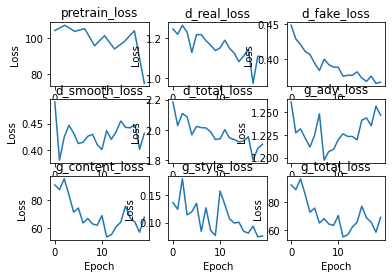

In [109]:
plot_logs()

In [104]:
new_logger = np.load(os.path.join(model_dir, 'logs.npy'), allow_pickle='TRUE').item()